In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# display all rows 
pd.set_option('display.max_rows', None)
#bank_max = pd.read_csv('fake_transactional_data_24.csv')

In [4]:
#head of the data
#bank_max.info()
#print(bank_max.shape)

In [5]:
mapped_df = pd.read_csv('mapped_df.csv')

In [6]:
mapped_df.shape

(10148280, 5)

In [7]:
mapped_df.head(10)

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date,group
0,10371.0,4.00,CINEMA,01/01/2025,Cinema
1,88339.0,2.40,40544,01/01/2025,NaN
2,18555.0,2.40,85149,01/01/2025,NaN
3,18555.0,4.10,HIPSTER_COFFEE_SHOP,01/01/2025,Cafe
4,80792.0,1.95,18555,01/01/2025,NaN
5,18555.0,4.45,TOTALLY_A_REAL_COFFEE_SHOP,01/01/2025,Cafe
6,18555.0,1.45,COFFEE_SHOP,01/01/2025,Cafe
7,18555.0,5.00,CAFE,01/01/2025,Cafe
8,41378.0,2.55,COFFEE_SHOP,01/01/2025,Cafe
9,41378.0,1.80,COFFEE_SHOP,01/01/2025,Cafe


Date comes in a day first format

In [8]:
# filter out rows where there is a numeric value in the 'to_randomly_generated_account' column - only looking at C2B payments
bank = mapped_df[mapped_df['to_randomly_generated_account'].str.isnumeric() == False]

In [9]:
bank.head(10)

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date,group
0,10371.0,4.00,CINEMA,01/01/2025,Cinema
3,18555.0,4.10,HIPSTER_COFFEE_SHOP,01/01/2025,Cafe
5,18555.0,4.45,TOTALLY_A_REAL_COFFEE_SHOP,01/01/2025,Cafe
6,18555.0,1.45,COFFEE_SHOP,01/01/2025,Cafe
7,18555.0,5.00,CAFE,01/01/2025,Cafe
8,41378.0,2.55,COFFEE_SHOP,01/01/2025,Cafe
9,41378.0,1.80,COFFEE_SHOP,01/01/2025,Cafe
10,4428.0,2.55,A_CAFE,01/01/2025,Cafe
11,4428.0,2.65,TOTALLY_A_REAL_COFFEE_SHOP,01/01/2025,Cafe
12,77222.0,4.50,LOCAL_RESTAURANT,01/01/2025,Restaurant/Takeaway


In [12]:
print(bank.shape)

(7615517, 5)


#### Verify categorised data hasn't removed any observations

In [13]:
# filter out rows where there is a numeric value in the 'to_randomly_generated_account' column - only looking at C2B payments
#bank1 = bank_max[bank_max['to_randomly_generated_account'].str.isnumeric() == False]

In [16]:
# check if bank1 and bank are the same
#bank1.head(10)

In [17]:
#bank1.shape

In [18]:
#sort the data by the 'to_randomly_generated_account' column - check account numbers have been removed from the beneficiary column
bank = bank.sort_values(by='to_randomly_generated_account', ascending=False)
bank.head()

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date,group
9474872,100214.0,74.99,WINE_CELLAR,09/12/2025,Alcohol Store
552937,61802.0,24.99,WINE_CELLAR,20/01/2025,Alcohol Store
7910414,11630.0,24.99,WINE_CELLAR,14/10/2025,Alcohol Store
552917,53177.0,74.99,WINE_CELLAR,20/01/2025,Alcohol Store
1935308,28673.0,24.99,WINE_CELLAR,11/03/2025,Alcohol Store


In [19]:
#concert 'not_happened_yet_date' to datetime format
bank['not_happened_yet_date'] = pd.to_datetime(bank['not_happened_yet_date'],dayfirst=True)

bank.head()

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date,group
9474872,100214.0,74.99,WINE_CELLAR,2025-12-09,Alcohol Store
552937,61802.0,24.99,WINE_CELLAR,2025-01-20,Alcohol Store
7910414,11630.0,24.99,WINE_CELLAR,2025-10-14,Alcohol Store
552917,53177.0,74.99,WINE_CELLAR,2025-01-20,Alcohol Store
1935308,28673.0,24.99,WINE_CELLAR,2025-03-11,Alcohol Store


In [20]:
# last date of the data
print(bank['not_happened_yet_date'].max())

2025-12-31 00:00:00


Now set our benchmark most recent time for recency score as the latest date

In [21]:
now = bank['not_happened_yet_date'].max() + pd.DateOffset(days=1)
print(now)

2026-01-01 00:00:00


In [22]:
# Create a new column and label a number for every time a transaction is made to a specific account in the 'to_randomly_generated_account' column
bank['transaction_freq_id'] = bank['from_totally_fake_account'] + 5

bank.head()
bank.shape

(7615517, 6)

use max instead of min for the recency to get lower scores first (which are better)

In [23]:
rfm = bank.groupby('from_totally_fake_account').agg({'not_happened_yet_date': lambda date: (now - date.max()).days, # recency
                                                     'transaction_freq_id': lambda num: len(num), # frequency
                                                     'monopoly_money_amount': lambda spend: spend.sum(), # monetary value
                                                     })

rfm.columns = ['recency', 'frequency', 'monetary']

(rfm.head(5))

,recency,frequency,monetary
from_totally_fake_account,,,
1000.0,1,1335,10485.46
1002.0,1,691,9155.67
1006.0,1,1553,14715.49
1018.0,2,687,11304.51
1053.0,1,1012,13139.22


In [24]:
# split the rececny, frequency and monetary into 4 quartiles. 

# more recent the transaction is, the lower the recency value. Should go in a lower quartile. I.e. best is the first quartile.
rfm['r_quartile'] = pd.qcut(rfm['recency'].rank(method='first'), q=4,labels=['4','3','2','1'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'].rank(method='first'), q=4, labels=['1','2','3','4'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'].rank(method='first'), q=4, labels=['1','2','3','4'])

In [25]:
rfm['RFM_Segment'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm['RFM_Score'] = rfm.r_quartile.astype(int) + rfm.f_quartile.astype(int) + rfm.m_quartile.astype(int)
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
from_totally_fake_account,,,,,,,,
1000.0,1,1335,10485.46,4,4,1,441,9
1002.0,1,691,9155.67,4,1,1,411,6
1006.0,1,1553,14715.49,4,4,3,443,11
1018.0,2,687,11304.51,1,1,2,112,4
1053.0,1,1012,13139.22,4,3,3,433,10


In [26]:
#show accounts with rfm score of 111 - worst lower quartile for recency, frequency and monetary
rfm[rfm['RFM_Segment']=='111'].head(5)

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
from_totally_fake_account,,,,,,,,
1059.0,2,678,10709.59,1,1,1,111,3
1122.0,2,672,10966.03,1,1,1,111,3
1142.0,2,522,9020.06,1,1,1,111,3
1357.0,2,651,9801.39,1,1,1,111,3
1622.0,4,463,9052.25,1,1,1,111,3


In [27]:
#show accounts with rfm score of 444 - best upper quartiles
rfm[rfm['RFM_Segment']=='444'].head(5)

# higher the rfm score, the better the customer is.

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score
from_totally_fake_account,,,,,,,,
1214.0,1,1331,18452.83,4,4,4,444,12
1507.0,1,1372,16676.08,4,4,4,444,12
1703.0,1,1712,16994.83,4,4,4,444,12
2076.0,1,1477,19285.30,4,4,4,444,12
2100.0,1,1370,16900.24,4,4,4,444,12


# RFM Score summary statistics

In [28]:
rfm.groupby('RFM_Score').agg({'recency': 'mean',
                              'frequency': 'mean',
                             'monetary': ['mean', 'count']}).round(1)


recency frequency monetary      
             mean      mean     mean count
RFM_Score                                 
3             2.7     565.0   9337.2   491
4             2.1     637.1  10640.1   604
5             1.7     684.6  11268.9   778
6             1.4     724.8  11840.2   956
7             1.2     830.8  12306.5  1103
8             1.1     942.7  13103.3  1147
9             1.0    1085.1  13894.8  1129
10            1.0    1227.2  15072.5  1047
11            1.0    1335.7  15810.8   622
12            1.0    1469.3  16564.0   265

The higher the RFM score, the lower the recency, higher the frequency and higher the monetary spend.

# K-means clustering - feature engineering


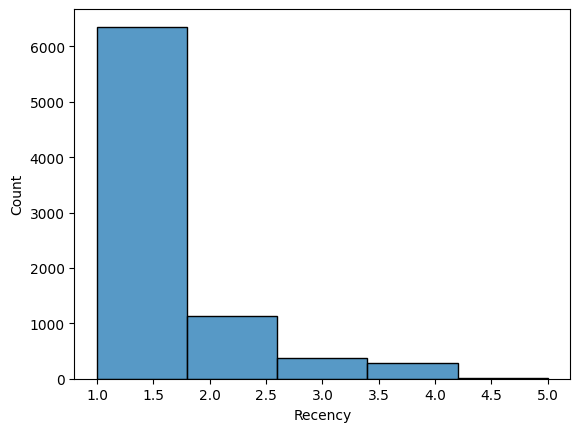

In [29]:
sns.histplot(rfm['recency'],bins=5)
plt.xlabel('Recency')
plt.show()

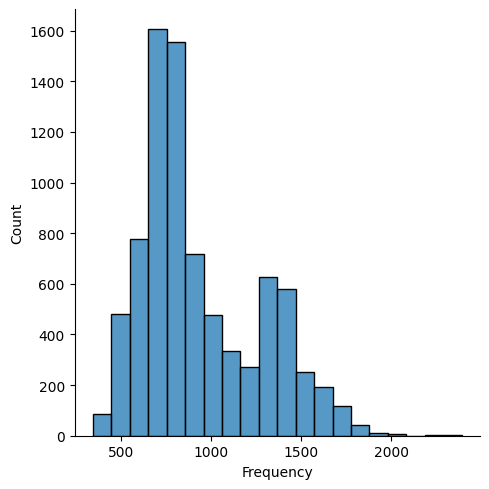

In [30]:
sns.displot(rfm['frequency'],bins=20)
plt.xlabel('Frequency')
plt.show()

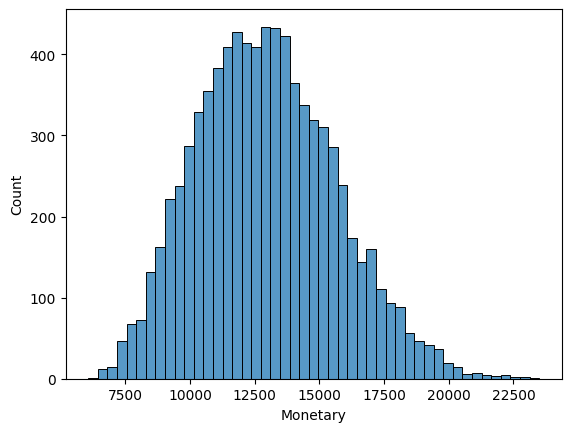

In [31]:
sns.histplot(rfm['monetary'])
plt.xlabel('Monetary')
plt.show()


All rfm features are log-normal and have a heavy right-skew

## Log transformation

In [32]:
rfm_features = rfm[['recency', 'frequency', 'monetary']]
rfm_features.head()


,recency,frequency,monetary
from_totally_fake_account,,,
1000.0,1,1335,10485.46
1002.0,1,691,9155.67
1006.0,1,1553,14715.49
1018.0,2,687,11304.51
1053.0,1,1012,13139.22


In [33]:
#create a new dataframe with the log of the rfm features
rfm_features_log = rfm_features.copy()
rfm_features_log['recency_log'] = np.log(rfm_features['recency'])
rfm_features_log['frequency_log'] = np.log(rfm_features['frequency'])
rfm_features_log['monetary_log'] = np.log(rfm_features['monetary'])
rfm_features_log.drop(['recency', 'frequency', 'monetary'], axis=1, inplace=True)


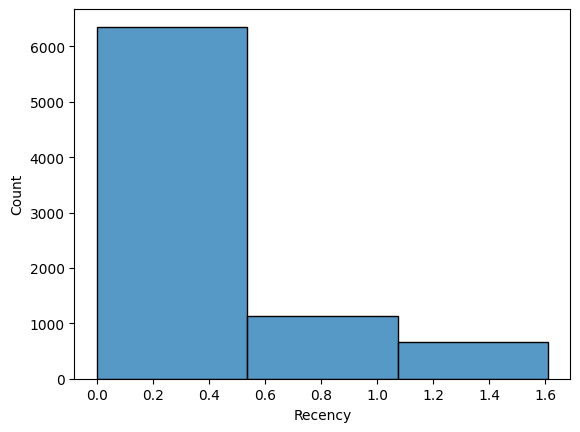

In [34]:
# plot the rfm features_log
sns.histplot(rfm_features_log['recency_log'],bins=3)
plt.xlabel('Recency')
plt.show()


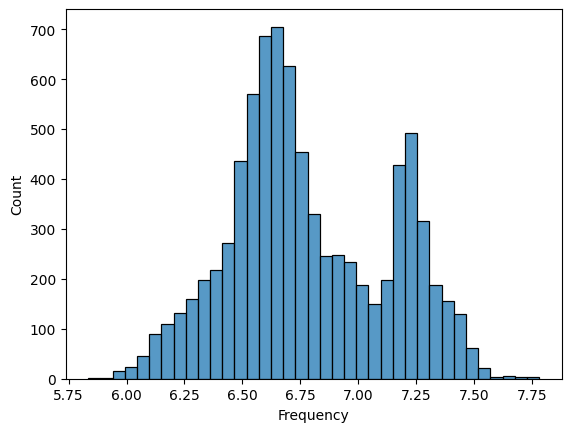

In [35]:
sns.histplot(rfm_features_log['frequency_log'])
plt.xlabel('Frequency')
plt.show()

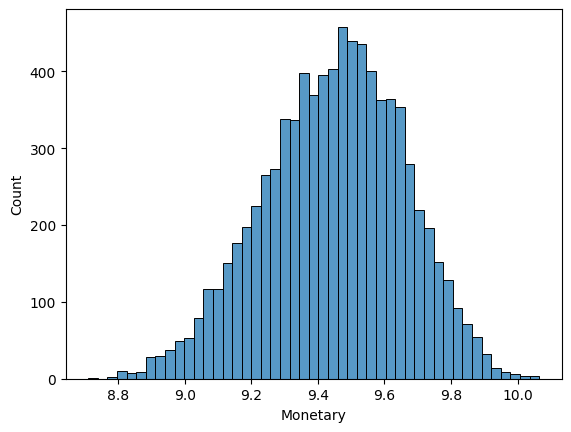

In [36]:
sns.histplot(rfm_features_log['monetary_log'])
plt.xlabel('Monetary')
plt.show()

# Standardising and scaling data

In [37]:
rfm.describe()

,recency,frequency,monetary,RFM_Score
count,8142.000000,8142.000000,8142.000000,8142.000000
mean,1.336895,935.337386,12944.370357,7.500000
std,0.729205,331.352131,2685.184598,2.402439
min,1.000000,342.000000,6063.340000,3.000000
25%,1.000000,699.000000,10980.735000,6.000000
50%,1.000000,818.000000,12829.960000,8.000000
75%,1.000000,1192.750000,14750.287500,9.000000
max,5.000000,2391.000000,23494.220000,12.000000


rfm features have different means and variances

In [38]:
#import standard scaler
from sklearn.preprocessing import StandardScaler

#standardize the data
scaler = StandardScaler()
scaler.fit(rfm_features_log)
rfm_normalized = scaler.transform(rfm_features_log)
rfm_normalized = pd.DataFrame(rfm_normalized, index=rfm_features.index, columns=rfm_features.columns)
rfm_normalized.describe().round(2)

,recency,frequency,monetary
count,8142.00,8142.00,8142.00
mean,0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-0.50,-2.78,-3.50
25%,-0.50,-0.68,-0.68
50%,-0.50,-0.22,0.06
75%,-0.50,0.89,0.72
max,3.63,2.92,2.93


As you can see all rfm features have been scaled to unit deviation and centred on the same mean

# K-Means Clustering

In [39]:
# Account IDs have been stored into the index.
rfm_normalized.head()   


,recency,frequency,monetary
from_totally_fake_account,,,
1000.0,-0.501287,1.216525,-0.896695
1002.0,-0.501287,-0.714062,-1.540641
1006.0,-0.501287,1.659948,0.712554
1018.0,1.276265,-0.731082,-0.539566
1053.0,-0.501287,0.404467,0.174577


In [40]:
# get column names of rfm_normalized
rfm_normalized.columns

rfm_normalized.head()

,recency,frequency,monetary
from_totally_fake_account,,,
1000.0,-0.501287,1.216525,-0.896695
1002.0,-0.501287,-0.714062,-1.540641
1006.0,-0.501287,1.659948,0.712554
1018.0,1.276265,-0.731082,-0.539566
1053.0,-0.501287,0.404467,0.174577


In [41]:
#import KMeans
from sklearn.cluster import KMeans

# Import silhouette_score
from sklearn.metrics import silhouette_score

# vary the number of clusters from 1 to 10
wcss = []
silhouette = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=1234)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)
    
    if i > 1:
        silhouette.append(silhouette_score(rfm_normalized, kmeans.labels_))
        
    

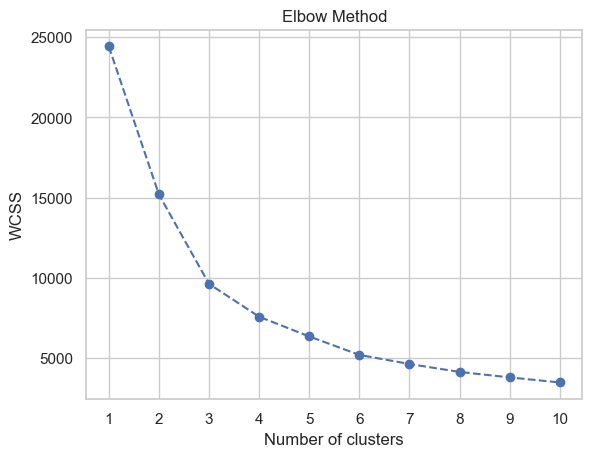

In [42]:
# plot the elbow graph
# point plot
sns.set(style='whitegrid')
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# add more x ticks
plt.xticks(np.arange(1, 11, 1))

plt.show()

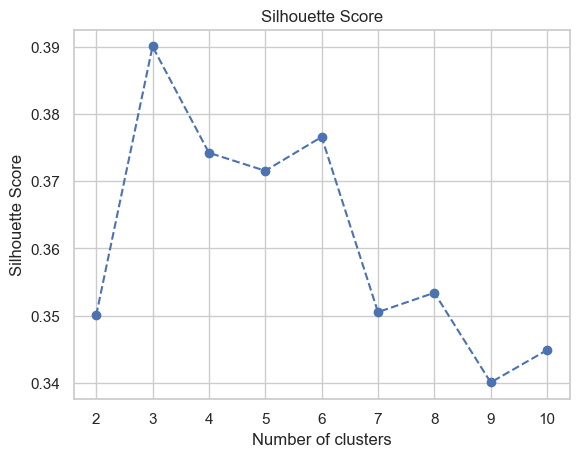

In [43]:
# plot the silhouette score
sns.set_style(style='whitegrid')
plt.plot(range(2, 11), silhouette, marker='o', linestyle='--')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


3 is the best number of clusters

In [44]:
# select k clusters
kmeans = KMeans(n_clusters=3, random_state=1234)
clusters = kmeans.fit_predict(rfm_normalized)


# Analysis of clustering

Summary statistics of the non-scaled RFM data with labelled clusters.

In [45]:
rfm_kmeans_cluster = rfm.assign(Cluster=clusters) 

# calculate average RFM values and size for each cluster
rfm_kmeans_cluster_summary=rfm_kmeans_cluster.groupby('Cluster').agg({'recency': 'mean',
                                            'frequency': 'mean',
                                            'monetary': ['mean','count']}).round(2)

rfm_kmeans_cluster_summary

recency frequency  monetary      
           mean      mean      mean count
Cluster                                  
0          1.01   1245.88  14906.27  3230
1          1.00    762.98  11515.27  3156
2          2.54    673.89  11904.11  1756

In [46]:
rfm_kmeans_cluster.head(5)

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score,Cluster
from_totally_fake_account,,,,,,,,,
1000.0,1,1335,10485.46,4,4,1,441,9,0
1002.0,1,691,9155.67,4,1,1,411,6,1
1006.0,1,1553,14715.49,4,4,3,443,11,0
1018.0,2,687,11304.51,1,1,2,112,4,2
1053.0,1,1012,13139.22,4,3,3,433,10,0


In [47]:
rfm_kmeans_cluster.shape

(8142, 9)

C:\Users\donjo\AppData\Local\Temp\ipykernel_10520\4082959746.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax_bar=sns.barplot(x=rfm_kmeans_cluster_summary.index, y=rfm_kmeans_cluster_summary['monetary']['count'], palette='viridis')
C:\Users\donjo\AppData\Local\Temp\ipykernel_10520\4082959746.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(np.arange(1,6))


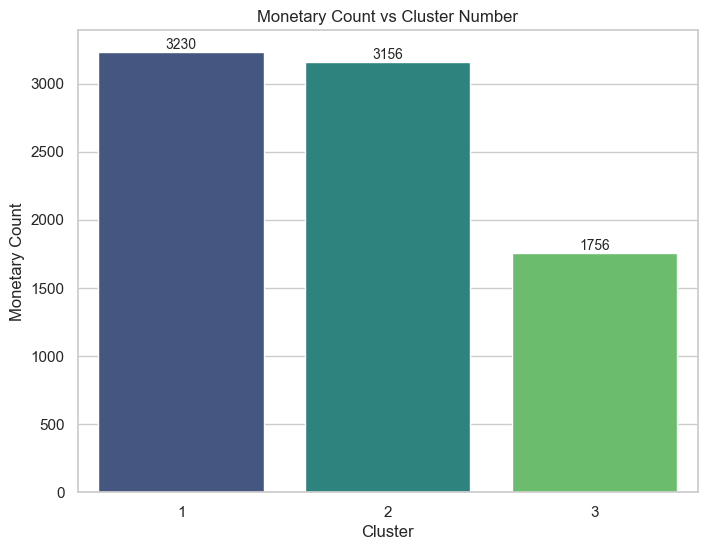

In [48]:
# plot monetary count vs cluster number
# increase plot size
plt.figure(figsize=(8, 6))

ax_bar=sns.barplot(x=rfm_kmeans_cluster_summary.index, y=rfm_kmeans_cluster_summary['monetary']['count'], palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Monetary Count')
plt.title('Monetary Count vs Cluster Number')
ax_bar.bar_label(ax_bar.containers[0], fontsize=10)
ax_bar.bar_label(ax_bar.containers[1], fontsize=10)
ax_bar.bar_label(ax_bar.containers[2], fontsize=10)
#ax_bar.bar_label(ax_bar.containers[3], fontsize=10)
#ax_bar.bar_label(ax_bar.containers[4], fontsize=10)
ax_bar.set_xticklabels(np.arange(1,6))


plt.show()

`count` column gives the number of accounts in each cluster - total of 8142 customers.

# Snake plots

Pivot wider, so each row represents one observations for a metric, given a specific account and cluster.

In [49]:
rfm_normalized['Cluster'] = rfm_kmeans_cluster['Cluster']  

# pivot wide for plotting
rfm_melt = pd.melt(rfm_normalized.reset_index(), 
                   id_vars=['from_totally_fake_account', 'Cluster'],
                   value_vars=['recency', 'frequency', 'monetary'],
                   var_name='Metric', value_name='Value')


Snake plots average values for each RFM metric for each cluster, using the original scaled and log transformed training data that has been labelled with KMeans assigned clusters.

Some negative values due to the Standardisation.

C:\Users\donjo\AppData\Local\Temp\ipykernel_10520\3245412977.py:8: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  snake=sns.lineplot(x='Metric',y='Value', hue='Cluster',palette=palette4, data=rfm_melt,err_style=None)


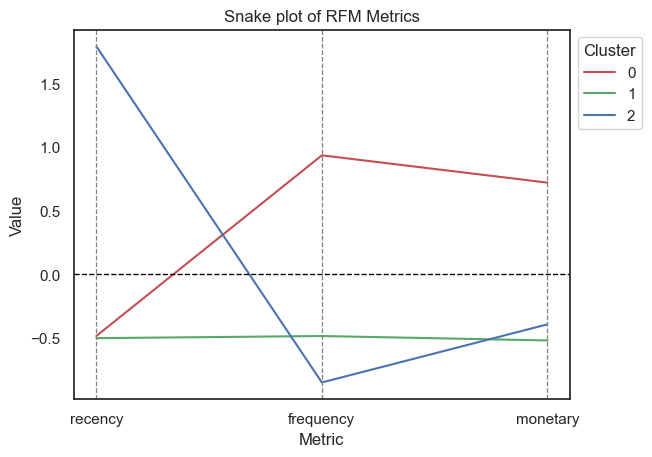

In [50]:
# visualize the clusters using a snake plot
sns.set(style='white')

# 3 cluster palette
palette4 =['r','g','b','y','m']

plt.title('Snake plot of RFM Metrics')
snake=sns.lineplot(x='Metric',y='Value', hue='Cluster',palette=palette4, data=rfm_melt,err_style=None)
sns.move_legend(snake, loc="upper left", bbox_to_anchor=(1, 1))
# vertical lines for each metric
plt.axvline(x=0, color='grey', linestyle='--',linewidth=0.9)
plt.axvline(x=1, color='grey', linestyle='--',linewidth=0.9)
plt.axvline(x=2, color='grey', linestyle='--',linewidth=0.9)
plt.axhline(y=0, color='black', linestyle='--',linewidth=1)
plt.show()


# Relative importance heatmaps and snake plots

In [51]:
rfm_kmeans_cluster.tail()
# drop every column except the cluster column and recency, frequency and monetary columns
rfm_kmeans_cluster_rel_imp = rfm_kmeans_cluster.drop(['r_quartile', 'f_quartile', 'm_quartile', 'RFM_Segment', 'RFM_Score'], axis=1)

rfm_rel_imp_calc=rfm.drop(['r_quartile', 'f_quartile', 'm_quartile', 'RFM_Segment', 'RFM_Score'], axis=1)

In [52]:
cluster_avg = rfm_kmeans_cluster_rel_imp.groupby(['Cluster']).mean()
population_avg = rfm_rel_imp_calc.mean()

# subtract 1 - to obtain relative importance 
# If you take a ratio, 1 = no difference from the population average
# if you subtract 1, 0 = no difference from the population average - easier to interpret.
relative_imp = (cluster_avg / population_avg) - 1

relative_imp.head()

,recency,frequency,monetary
Cluster,,,
0,-0.244588,0.332012,0.151564
1,-0.251998,-0.184271,-0.110403
2,0.902804,-0.279523,-0.080364


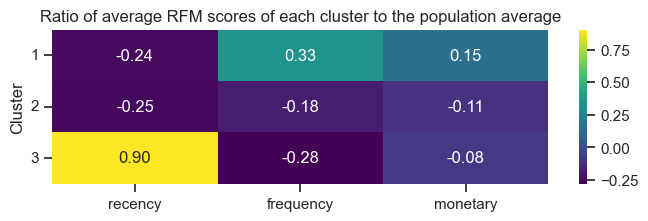

In [53]:
#

# plot the relative importance of the RFM values for each cluster
plt.figure(figsize=(8, 2))
plt.title('Ratio of average RFM scores of each cluster to the population average')

# rotate the y axis labels
plt.yticks(rotation=60)

ax_heat=sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='viridis')
ax_heat.yaxis.tick_left()
ax_heat.xaxis.tick_bottom()

#rotate the y axis tick labels and rename the cluster numbers from [1-5]
ax_heat.set_yticklabels(np.arange(1,4), rotation=0)

plt.show()

Further the relative score is from 0, the more important that property is to that particular cluster as compared to the population average.

In [54]:
# snake plot of average RFM scores against population average
relative_imp = relative_imp.reset_index()
relative_imp_melt = pd.melt(relative_imp, id_vars=['Cluster'], value_vars=['recency', 'frequency', 'monetary'], var_name='Metric', value_name='Value')

# rename the cluster numbers from 0-4 to 1-5 - useful for visualisation
relative_imp_melt['Cluster'] = relative_imp_melt['Cluster'] + 1

In [55]:
relative_imp_melt.head()

,Cluster,Metric,Value
0,1,recency,-0.244588
1,2,recency,-0.251998
2,3,recency,0.902804
3,1,frequency,0.332012
4,2,frequency,-0.184271


C:\Users\donjo\AppData\Local\Temp\ipykernel_10520\2689878380.py:4: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  snake=sns.lineplot(x='Metric',y='Value', hue='Cluster',palette=palette4, data=relative_imp_melt,err_style=None)


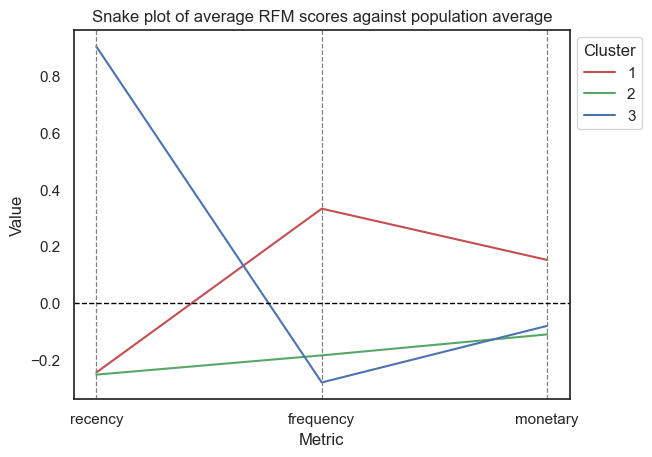

In [56]:
# Plot the snake plot
sns.set(style='white')
plt.title('Snake plot of average RFM scores against population average')
snake=sns.lineplot(x='Metric',y='Value', hue='Cluster',palette=palette4, data=relative_imp_melt,err_style=None)
sns.move_legend(snake, loc="upper left", bbox_to_anchor=(1, 1))
plt.axvline(x=0, color='grey', linestyle='--',linewidth=0.9)
plt.axvline(x=1, color='grey', linestyle='--',linewidth=0.9)
plt.axvline(x=2, color='grey', linestyle='--',linewidth=0.9)
plt.axhline(y=0, color='black', linestyle='--',linewidth=1)

# rename cluster number from 0-4 to 1-5

plt.show()


# Spending behaviours for each cluster


In [57]:
rfm_melt['from_totally_fake_account'].nunique()
rfm_melt.head(10)

,from_totally_fake_account,Cluster,Metric,Value
0,1000.0,0,recency,-0.501287
1,1002.0,1,recency,-0.501287
2,1006.0,0,recency,-0.501287
3,1018.0,2,recency,1.276265
4,1053.0,0,recency,-0.501287
5,1059.0,2,recency,1.276265
6,1071.0,1,recency,-0.501287
7,1078.0,1,recency,-0.501287
8,1086.0,0,recency,-0.501287
9,1087.0,1,recency,-0.501287


### Merchant categorisation

We're going to merge the rfm_kmeans_cluster dataframe onto the mapped C2B bank transactional dataset, to see the cluster each transa

In [58]:
# join the rfm_kmeans_cluster dataframe with the original bank dataframe on the 'from_totally_fake_account' column 
rfm_merged = bank.merge(rfm_kmeans_cluster, on='from_totally_fake_account')

In [59]:
rfm_merged.head(10).sort_values(by='group')

rfm_merged.shape

(7615517, 15)

In [60]:
# print number of rows in rfm_merged - many more as we have multiple metrics for each account
print(rfm_merged.shape)

rfm_merged.head()

(7615517, 15)


,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date,group,transaction_freq_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score,Cluster
0,100214.0,74.99,WINE_CELLAR,2025-12-09,Alcohol Store,100219.0,1,852,11903.53,1,3,2,132,6,1
1,61802.0,24.99,WINE_CELLAR,2025-01-20,Alcohol Store,61807.0,1,1064,14597.36,3,3,3,333,9,0
2,11630.0,24.99,WINE_CELLAR,2025-10-14,Alcohol Store,11635.0,1,961,13774.66,4,3,3,433,10,0
3,53177.0,74.99,WINE_CELLAR,2025-01-20,Alcohol Store,53182.0,1,820,15087.26,3,3,4,334,10,0
4,28673.0,24.99,WINE_CELLAR,2025-03-11,Alcohol Store,28678.0,3,611,10780.31,1,1,1,111,3,2


#### Cluster 0 summary stats

In [61]:
# filter rfm_merged for 'Cluster' == 0 and save to rfm_merged_cluster_0
rfm_merged_cluster_0 = rfm_merged[rfm_merged['Cluster'] == 0]

In [62]:
rfm_merged_cluster_0.head(5)

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date,group,transaction_freq_id,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Segment,RFM_Score,Cluster
1,61802.0,24.99,WINE_CELLAR,2025-01-20,Alcohol Store,61807.0,1,1064,14597.36,3,3,3,333,9,0
2,11630.0,24.99,WINE_CELLAR,2025-10-14,Alcohol Store,11635.0,1,961,13774.66,4,3,3,433,10,0
3,53177.0,74.99,WINE_CELLAR,2025-01-20,Alcohol Store,53182.0,1,820,15087.26,3,3,4,334,10,0
5,19533.0,9.00,WINE_CELLAR,2025-08-11,Alcohol Store,19538.0,1,1464,15779.93,4,4,4,444,12,0
10,75868.0,49.99,WINE_CELLAR,2025-12-15,Alcohol Store,75873.0,1,1508,19505.52,2,4,4,244,10,0


In [63]:
mean_spend_c0 = rfm_merged_cluster_0.groupby('group').agg(
                                                            mean_spend = ('monopoly_money_amount','mean'),
                                                            total_spend = ('monopoly_money_amount','sum')).reset_index()


# rename 'monopoly_money_amount' column to 'average_spend'
#mean_spend_c0.rename(columns={'monopoly_money_amount':'mean_spend'}, inplace=True)

# calculate percentage of total spend for each group
mean_spend_c0['percentage_of_total_spend'] = (mean_spend_c0['total_spend'] / mean_spend_c0['total_spend'].sum()) * 100

mean_spend_c0.sort_values(by='percentage_of_total_spend', ascending=False)

,group,mean_spend,total_spend,percentage_of_total_spend
23,Supermarket,69.361454,10235114.91,21.257944
2,Bar,10.898364,8619200.00,17.901751
19,Restaurant/Takeaway,24.830895,5261343.90,10.927611
18,Pub,14.032249,5190107.84,10.779657
5,Cafe,2.490974,4575065.55,9.502237
8,Clothing Store,114.658173,2960818.00,6.149506
6,Children's Shop,55.270098,2203453.00,4.576488
10,Department Store,115.815362,1527373.00,3.172296
11,Fast Food,4.397472,1225127.00,2.544542
4,Butcher,22.197592,1090456.73,2.264837


#### Cluster 0 total visits

In [64]:
count_spend_c0 = rfm_merged_cluster_0.groupby('group').agg({'monopoly_money_amount':'count'}).reset_index()
count_spend_c0.rename(columns={'monopoly_money_amount':'count_spend'}, inplace=True)
#count_spend_c0.sort_values(by='count_spend', ascending=False)

In [65]:
count_spend_c0['Percentage'] = (count_spend_c0['count_spend'] / count_spend_c0['count_spend'].sum()) * 100

count_spend_c0.sort_values(by='Percentage', ascending=False)

,group,count_spend,Percentage
5,Cafe,1836657,45.640358
2,Bar,790871,19.652900
18,Pub,369870,9.191155
11,Fast Food,278598,6.923074
19,Restaurant/Takeaway,211887,5.265326
23,Supermarket,147562,3.666870
3,Book Store,57925,1.439418
7,Cinema,57582,1.430895
4,Butcher,49125,1.220741
14,Greengrocer,48869,1.214380


#### Cluster 1 mean spend summary stats

In [66]:
# filter rfm_merged for 'Cluster' == 0 and save to rfm_merged_cluster_1
rfm_merged_cluster_1 = rfm_merged[rfm_merged['Cluster'] == 1]

In [67]:
mean_spend_c1 = rfm_merged_cluster_1.groupby('group').agg(
                                                            mean_spend = ('monopoly_money_amount','mean'),
                                                            total_spend = ('monopoly_money_amount','sum')).reset_index()

mean_spend_c1['Percentage_of_total_spend'] = (mean_spend_c1['total_spend'] / mean_spend_c1['total_spend'].sum()) * 100

mean_spend_c1.sort_values(by='Percentage_of_total_spend', ascending=False)

,group,mean_spend,total_spend,Percentage_of_total_spend
2,Bar,11.047759,7919630.00,21.791831
23,Supermarket,68.087009,7622749.15,20.974927
19,Restaurant/Takeaway,28.682025,4927744.02,13.559291
18,Pub,14.399237,4852370.10,13.351890
5,Cafe,2.508510,1592520.30,4.382014
8,Clothing Store,113.957170,1567139.00,4.312175
6,Children's Shop,54.927061,1413493.00,3.889399
4,Butcher,22.026081,851902.75,2.344115
14,Greengrocer,21.808754,835362.52,2.298602
10,Department Store,114.997488,778188.00,2.141279


#### Cluster 1 total visits

In [68]:
count_spend_c1 = rfm_merged_cluster_1.groupby('group').agg({'monopoly_money_amount':'count'}).reset_index()
count_spend_c1.rename(columns={'monopoly_money_amount':'count_spend'}, inplace=True)
#count_spend_c1.sort_values(by='count_spend', ascending=False)

In [69]:
count_spend_c1['Percentage'] = (count_spend_c1['count_spend'] / count_spend_c1['count_spend'].sum()) * 100

count_spend_c1.sort_values(by='Percentage', ascending=False)

,group,count_spend,Percentage
2,Bar,716854,29.770031
5,Cafe,634847,26.364385
18,Pub,336988,13.994681
19,Restaurant/Takeaway,171806,7.134884
11,Fast Food,135893,5.643463
23,Supermarket,111956,4.649390
7,Cinema,50296,2.088729
3,Book Store,45872,1.905006
4,Butcher,38677,1.606206
14,Greengrocer,38304,1.590716


#### Cluster 2 mean spend summary stats

In [70]:
# filter rfm_merged for 'Cluster' == 0 and save to rfm_merged_cluster_0
rfm_merged_cluster_2 = rfm_merged[rfm_merged['Cluster'] == 2]

In [71]:
mean_spend_c2 = rfm_merged_cluster_2.groupby('group').agg({'monopoly_money_amount':'mean'}).reset_index()

# rename 'monopoly_money_amount' column to 'average_spend'
mean_spend_c2.rename(columns={'monopoly_money_amount':'mean_spend'}, inplace=True) 
mean_spend_c2.sort_values(by='mean_spend', ascending=False)

,group,mean_spend
24,Tech Store,162.347124
10,Department Store,115.652896
8,Clothing Store,114.852168
21,Sports Store,75.279183
23,Supermarket,70.981514
25,Turkey Farm,58.091483
6,Children's Shop,55.024081
16,Home,46.963834
13,Gaming,40.121030
19,Restaurant/Takeaway,31.975612


#### Cluster 2 total visits

In [72]:
count_spend_c2 = rfm_merged_cluster_2.groupby('group').agg({'monopoly_money_amount':'count'}).reset_index()
count_spend_c2.rename(columns={'monopoly_money_amount':'count_spend'}, inplace=True)
#count_spend_c2.sort_values(by='count_spend', ascending=False)

In [73]:
count_spend_c2['Percentage'] = (count_spend_c2['count_spend'] / count_spend_c2['count_spend'].sum()) * 100

count_spend_c2.sort_values(by='Percentage', ascending=False)

,group,count_spend,Percentage
2,Bar,402922,34.049267
5,Cafe,239033,20.199687
18,Pub,188189,15.903072
19,Restaurant/Takeaway,84018,7.100013
23,Supermarket,67399,5.695610
11,Fast Food,30242,2.555626
7,Cinema,27523,2.325855
3,Book Store,25094,2.120590
4,Butcher,20436,1.726962
14,Greengrocer,20351,1.719779


#### Analysis of the clusters

- Cluster 0 (1) has a significantly higher volumes of transactions going to cafes and coffee shops.
- Higher percentage volume going to fast food compared to restaurants/takeaways or supermarkets shops (unlike the other 2 clusters)
- 

#### Cluster visualisations

In [74]:
# Plot Monetary Value vs Frequency for each cluster
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x='frequency', y='monetary', hue='Cluster', data=rfm_merged, palette=palette4)
plt.title('Monetary Value vs Frequency for each cluster')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.show()


C:\Users\donjo\AppData\Local\Temp\ipykernel_10520\2125637994.py:4: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.scatterplot(x='frequency', y='monetary', hue='Cluster', data=rfm_merged, palette=palette4)


KeyboardInterrupt: 

#### Aggregated per category spend

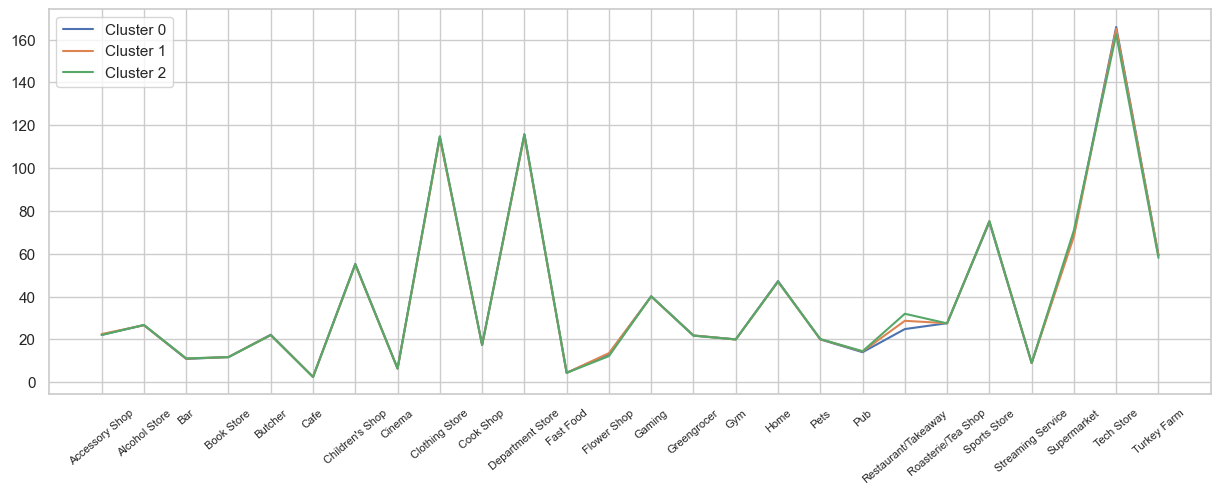

In [ ]:
# plot the mean_spend for each cluster snake plot
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid')

# add mean_spend for cluster 0
plt.plot(mean_spend_c0['group'], mean_spend_c0['mean_spend'], label='Cluster 0')

# add mean_spend for cluster 1
plt.plot(mean_spend_c1['group'], mean_spend_c1['mean_spend'], label='Cluster 1')

# add mean_spend for cluster 2
plt.plot(mean_spend_c2['group'], mean_spend_c2['mean_spend'], label='Cluster 2')

# add mean_spend for cluster 3
#plt.plot(mean_spend_c3['group'], mean_spend_c3['mean_spend'], label='Cluster 3')

# add mean_spend for cluster 4
#plt.plot(mean_spend_c4['group'], mean_spend_c4['mean_spend'], label='Cluster 4')

# rotate x axis ticks
plt.xticks(rotation=40)

#decrease size of x ticks
plt.xticks(fontsize=8)

# add legend
plt.legend()


In [ ]:
mean_spend_c3.head(30)


,group,mean_spend
